In [67]:
!pip install soundfile

import pandas as pd
import numpy as np
import io
import soundfile as sf
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
import librosa
import librosa.display

In [68]:
# Load dataset
splits = {'train': 'data/train-00000-of-00001.parquet',
          'test': 'data/test-00000-of-00001.parquet'}

df = pd.read_parquet("hf://datasets/mteb/free-spoken-digit-dataset/" + splits["train"])
print(df.head())

                                               audio  label
0  {'bytes': b'RIFF\xb0.\x00\x00WAVEfmt \x10\x00\...      0
1  {'bytes': b'RIFF\xbe\x1c\x00\x00WAVEfmt \x10\x...      0
2  {'bytes': b'RIFF\xc8\x1f\x00\x00WAVEfmt \x10\x...      0
3  {'bytes': b'RIFF\x1e"\x00\x00WAVEfmt \x10\x00\...      0
4  {'bytes': b'RIFF\xc4!\x00\x00WAVEfmt \x10\x00\...      0


Sample Index: 792, Label: 2, Sample Rate: 8000, Signal Shape: (3067,)


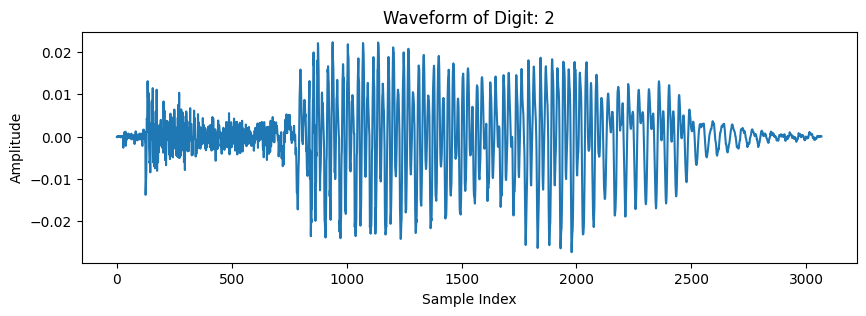

Sample Index: 2148, Label: 7, Sample Rate: 8000, Signal Shape: (3218,)


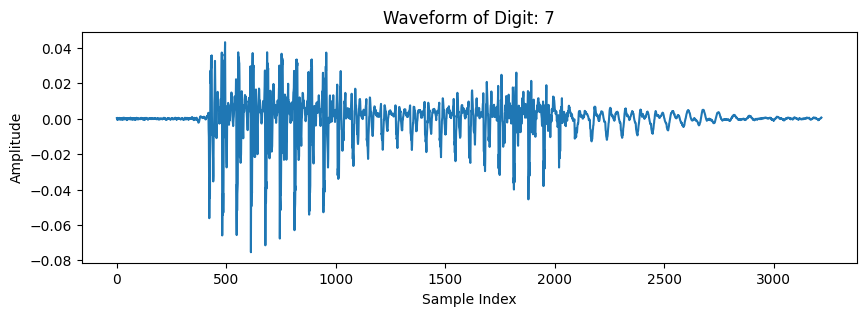

Sample Index: 340, Label: 1, Sample Rate: 8000, Signal Shape: (3982,)


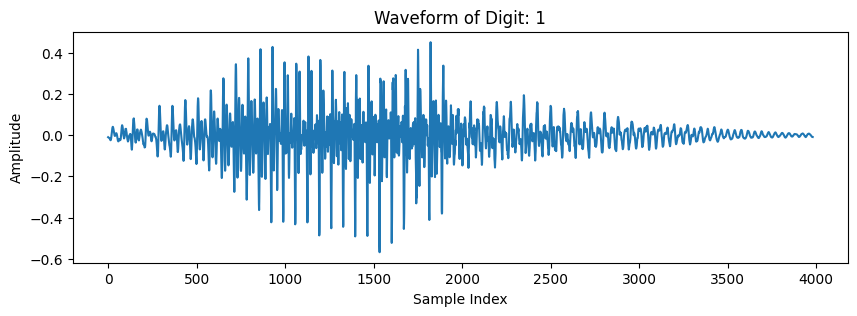

In [69]:
# Pick 3 random samples
samples = df.sample(3)

for idx, sample in samples.iterrows():
    audio_bytes = sample['audio']['bytes']
    label = sample['label']

    # Convert bytes to waveform
    signal, sr = sf.read(io.BytesIO(audio_bytes))
    print(f"Sample Index: {idx}, Label: {label}, Sample Rate: {sr}, Signal Shape: {signal.shape}")

    # Play audio
    display(ipd.Audio(signal, rate=sr))

    # Plot waveform
    plt.figure(figsize=(10, 3))
    plt.plot(signal)
    plt.title(f"Waveform of Digit: {label}")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.show()

In [70]:
import numpy as np
import librosa
import soundfile as sf
import io

# Function to extract MFCC features from raw audio bytes
def extract_mfcc(audio_bytes, n_mfcc=13):
    # Decode audio bytes into waveform
    signal, sr = sf.read(io.BytesIO(audio_bytes))


    # Compute MFCCs
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)

    # Average across time to get fixed-length vector
    mfccs_mean = np.mean(mfccs.T, axis=0)

    return mfccs_mean

# Example: Extract MFCCs from 5 random samples
features = []
labels = []

for idx, row in df.sample(5).iterrows():
    mfcc_vector = extract_mfcc(row['audio']['bytes'])
    features.append(mfcc_vector)
    labels.append(row['label'])

features = np.array(features)
labels = np.array(labels)

print("Feature array shape:", features.shape)
print("Labels:", labels)


Feature array shape: (5, 13)
Labels: [5 6 4 1 6]


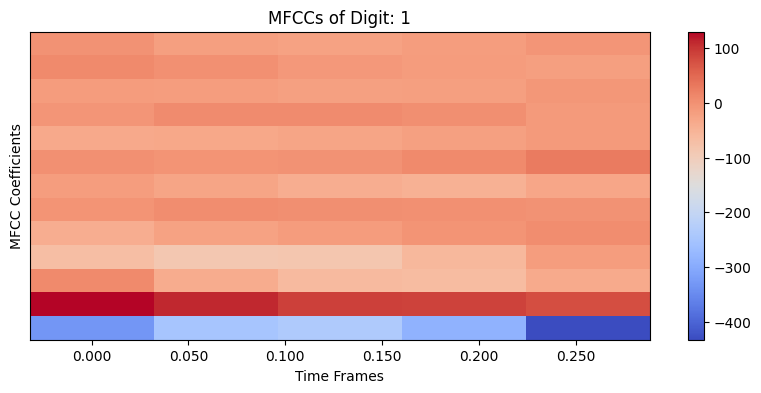

In [71]:
import librosa.display

# Picking one random sample from the dataset
sample = df.sample(1).iloc[0]
audio_bytes = sample['audio']['bytes']
label = sample['label']

# Decode audio
signal, sr = sf.read(io.BytesIO(audio_bytes))

# Compute MFCCs
mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)

# Plot MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar()
plt.title(f"MFCCs of Digit: {label}")
plt.ylabel("MFCC Coefficients")
plt.xlabel("Time Frames")
plt.show()


X-axis = time frames of the audio.

Y-axis = 13 MFCC coefficients (each row is one coefficient).

Color intensity = magnitude of each coefficient.

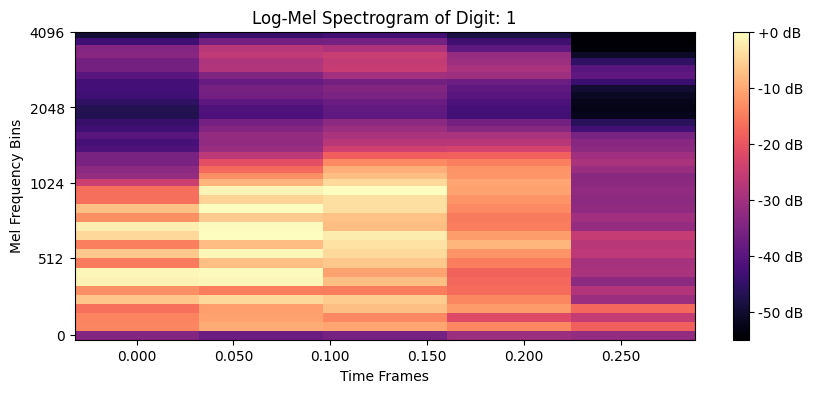

In [72]:
# Compute Mel Spectrogram
S = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=40)

# Convert to log scale (dB)
log_S = librosa.power_to_db(S, ref=np.max)

# Plot
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_S, x_axis='time', y_axis='mel', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title(f"Log-Mel Spectrogram of Digit: {label}")
plt.ylabel("Mel Frequency Bins")
plt.xlabel("Time Frames")
plt.show()


In [73]:
import numpy as np
from tqdm import tqdm
import librosa
import soundfile as sf
import io

# Function to extract MFCC + Log-Mel features
def extract_full_features(audio_bytes, n_mfcc=13, n_mels=40):
    # Decode audio bytes
    signal, sr = sf.read(io.BytesIO(audio_bytes))

    # MFCC
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs.T, axis=0)

    # Log-Mel Spectrogram
    S = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels)
    log_S = librosa.power_to_db(S, ref=np.max)
    logmel_mean = np.mean(log_S.T, axis=0)

    # Concatenate features
    return np.concatenate([mfccs_mean, logmel_mean])

# Initialize lists
features = []
labels = []

# Loop through the entire dataset
for idx, row in tqdm(df.iterrows(), total=len(df)):
    feat_vector = extract_full_features(row['audio']['bytes'])
    features.append(feat_vector)
    labels.append(row['label'])

# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)


 11%|█         | 291/2700 [00:07<00:57, 41.66it/s]/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1933
  warnings.warn(
 11%|█         | 297/2700 [00:07<00:52, 45.44it/s]/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1399
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1876
  warnings.warn(
 14%|█▍        | 377/2700 [00:08<00:51, 45.22it/s]/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1983
  warnings.warn(
 15%|█▌        | 410/2700 [00:09<00:39, 57.96it/s]/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2033
  warnings.warn(
/usr/local/lib/pytho

Feature matrix shape: (2700, 53)
Labels shape: (2700,)


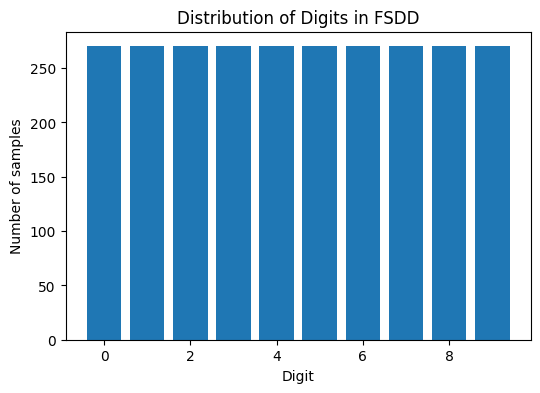

In [74]:
import matplotlib.pyplot as plt

# 1️⃣ Label distribution
plt.figure(figsize=(6,4))
plt.bar(range(10), [sum(y==i) for i in range(10)])
plt.xlabel("Digit")
plt.ylabel("Number of samples")
plt.title("Distribution of Digits in FSDD")
plt.show()

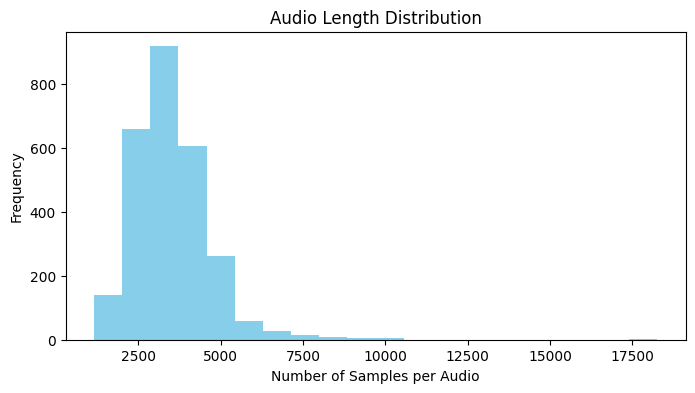

In [75]:
# 2️⃣ Audio length distribution
audio_lengths = [len(sf.read(io.BytesIO(row['audio']['bytes']))[0]) for idx, row in df.iterrows()]
plt.figure(figsize=(8,4))
plt.hist(audio_lengths, bins=20, color='skyblue')
plt.xlabel("Number of Samples per Audio")
plt.ylabel("Frequency")
plt.title("Audio Length Distribution")
plt.show()


Histogram of audio lengths (number of samples per clip).

Most audio clips are approximately 1–2 seconds long, but a few are shorter. This helps us understand the variability in input lengths, which is important for feature extraction like MFCCs.

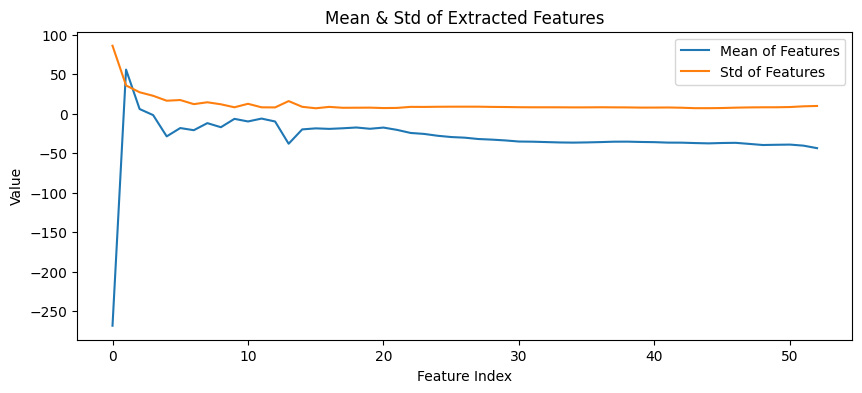

In [76]:
# 3️⃣ Feature statistics
plt.figure(figsize=(10,4))
plt.plot(np.mean(X, axis=0), label='Mean of Features')
plt.plot(np.std(X, axis=0), label='Std of Features')
plt.xlabel("Feature Index")
plt.ylabel("Value")
plt.title("Mean & Std of Extracted Features")
plt.legend()
plt.show()


Line plot of the mean and standard deviation for each extracted feature (MFCCs + log-Mel features).

MFCC features were extracted from each audio sample. The plot above shows the mean and standard deviation across all features, highlighting which coefficients carry the most variation and might be most informative for classification.

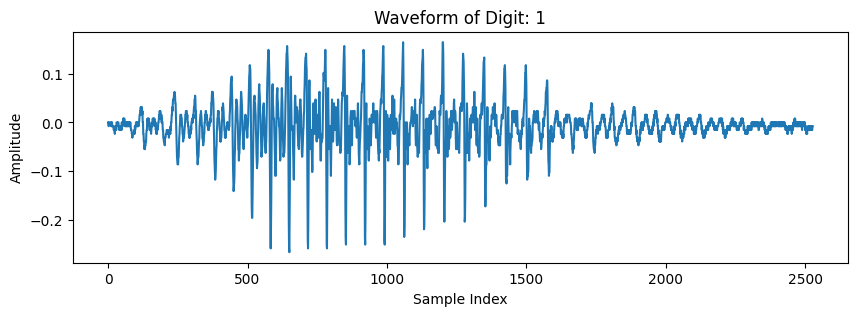

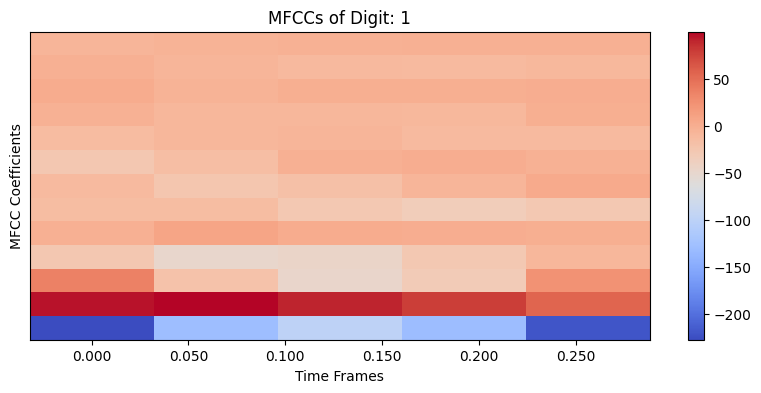

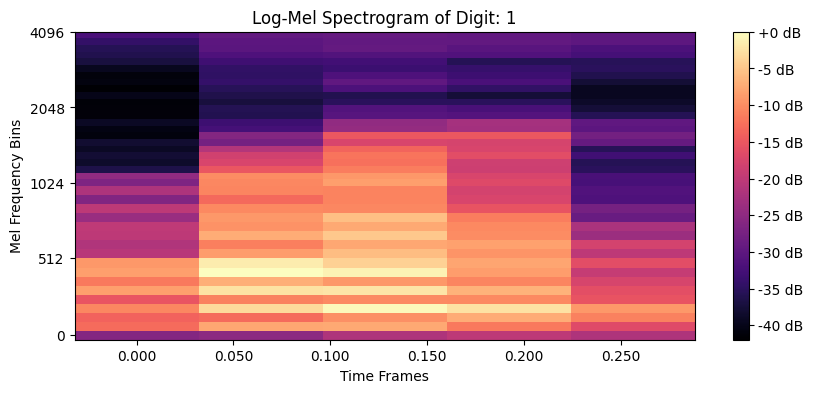

In [77]:
# Pick one random sample
sample = df.sample(1).iloc[0]
audio_bytes = sample['audio']['bytes']
label = sample['label']

# Decode audio
signal, sr = sf.read(io.BytesIO(audio_bytes))

# Play audio
display(ipd.Audio(signal, rate=sr))

# Plot waveform
plt.figure(figsize=(10,3))
plt.plot(signal)
plt.title(f"Waveform of Digit: {label}")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

# Compute MFCCs
mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)

plt.figure(figsize=(10,4))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar()
plt.title(f"MFCCs of Digit: {label}")
plt.ylabel("MFCC Coefficients")
plt.xlabel("Time Frames")
plt.show()

# Compute Log-Mel Spectrogram
S = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=40)
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(10,4))
librosa.display.specshow(log_S, x_axis='time', y_axis='mel', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title(f"Log-Mel Spectrogram of Digit: {label}")
plt.ylabel("Mel Frequency Bins")
plt.xlabel("Time Frames")
plt.show()


In [78]:
# Print first 5 feature vectors
print("First 5 MFCC feature vectors:")
print(features[:5])

# Check the shape of a single feature vector
print("\nShape of a single feature vector:", features[0].shape)

# Optional: print min, max, mean for each coefficient
print("\nFeature statistics (mean, min, max) across first sample:")
print("Mean:", np.mean(features[0]))
print("Min:", np.min(features[0]))
print("Max:", np.max(features[0]))


First 5 MFCC feature vectors:
[array([-3.12191860e+02,  1.11998218e+01, -4.55752092e-01,  6.47128271e+00,
       -3.75233705e+01, -3.61163616e+01, -2.44615471e+01, -3.55630805e+01,
       -3.30416492e+01, -1.17255657e+01, -3.28100616e+01, -2.62404152e-01,
       -1.49755675e+01, -7.59361336e+01, -3.41800677e+01, -2.75848940e+01,
       -3.55734746e+01, -2.33346964e+01, -2.37815248e+01, -3.12011667e+01,
       -2.22092175e+01, -3.03738673e+01, -4.41696743e+01, -3.85152649e+01,
       -4.34938679e+01, -4.16685152e+01, -4.29874192e+01, -4.68697550e+01,
       -4.34159739e+01, -4.60056488e+01, -4.76947405e+01, -4.67012705e+01,
       -4.68078840e+01, -4.43013557e+01, -4.52508658e+01, -4.32477567e+01,
       -4.51631205e+01, -4.37903415e+01, -4.09094209e+01, -3.80091195e+01,
       -3.61310816e+01, -3.62586688e+01, -3.83089423e+01, -4.26907775e+01,
       -4.73637435e+01, -4.79059228e+01, -4.56592863e+01, -4.63501845e+01,
       -4.66179968e+01, -4.27408407e+01, -4.03568918e+01, -4.37928598

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# 1. Split dataset
indices = np.arange(len(features))  # Track original row indices
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    features, labels, indices, test_size=0.2, random_state=42, stratify=labels
)

In [80]:
# 2. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [81]:

# 3. Train Logistic Regression
clf = LogisticRegression(max_iter=500)
clf.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=500)

In [82]:
# 4. Evaluate
y_pred = clf.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc*100:.2f}%")

Test Accuracy: 89.63%


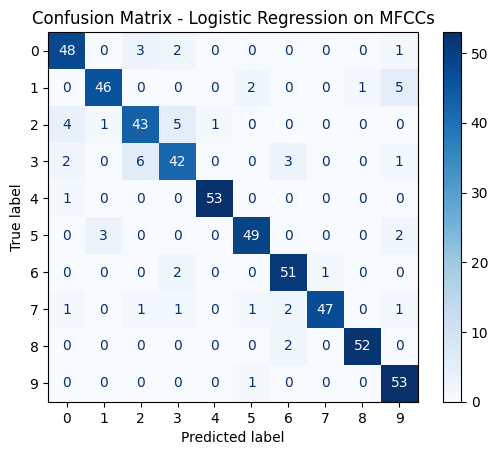

In [83]:
# 5. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression on MFCCs")
plt.show()

In [84]:
# 6. Predict on one random test sample with original audio
sample_idx = np.random.randint(len(X_test))
sample_features = X_test_scaled[sample_idx].reshape(1, -1)
sample_label = y_test[sample_idx]
pred_label = clf.predict(sample_features)[0]

print(f"True Label: {sample_label}, Predicted: {pred_label}")

# Retrieve original audio from df using original index
original_df_idx = idx_test[sample_idx]  # Maps to original df
original_audio_bytes = df.iloc[original_df_idx]['audio']['bytes']
signal, sr = sf.read(io.BytesIO(original_audio_bytes))

# Play the audio
display(ipd.Audio(signal, rate=sr))

True Label: 4, Predicted: 4


In [103]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.15).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [104]:
!git config --global user.email "mdbprasad414@gmail.com"
!git config --global user.name "PrasadSingh"

In [106]:
!git clone https://github.com/PrasadSingh/Digit-Classification-from-Audio.git

Cloning into 'Digit-Classification-from-Audio'...


In [108]:
!mv Classification from Audio.ipynb Digit-Classification-from-Audio/

mv: cannot stat 'Classification': No such file or directory
mv: cannot stat 'from': No such file or directory
mv: cannot stat 'Audio.ipynb': No such file or directory
